In [1]:
def distance_calculator(objects, object_code, grid_size, object_distance):
    # objects should be 3D arrays with 1st dim as years and 2nd-3rd dim as maps of those years
    # object code is the number signifying the object in the maps
    # grid size should be in meters (side length of square grid cell)
    # object distance is the output file that is taken as input with some default value - largest possible distance (diagonal)
    for k in range(np.shape(objects)[0]):
        ids = np.indices((np.shape(objects[k])[0],np.shape(objects[k])[1]))
        idx = np.where(objects[k]==object_code)
        for i in range(np.shape(idx)[1]):
            X = np.ones([np.shape(objects[k])[0], np.shape(objects[k])[1]])*idx[0][i]
            Y = np.ones([np.shape(objects[k])[0], np.shape(objects[k])[1]])*idx[1][i]
            dist = np.sqrt(np.square(X-ids[0])+np.square(Y-ids[1]))*(grid_size/1000)
            object_distance[k] = np.minimum(object_distance[k],dist)
            
    return object_distance

In [2]:
def intrinsic_values(LULC_maps, object_codes):
    seperated_maps = np.empty([np.shape(object_codes)[0],np.shape(LULC_maps)[0],np.shape(LULC_maps)[1],np.shape(LULC_maps)[2]])
    for p in range(np.shape(seperated_maps)[0]):
        seperated_maps[p] = LULC_maps
        for k in range(np.shape(seperated_maps)[1]):
            seperated_maps[p][k][seperated_maps[p][k]!=object_codes[p]] = 0
            seperated_maps[p][k][seperated_maps[p][k]==object_codes[p]] = 1
            
    return seperated_maps

In [3]:
def Cellular_Automata(seperated_maps, neighbourhood_size):
    LULC_prop_map = np.empty(np.shape(seperated_maps))
    slider = np.ones([neighbourhood_size,neighbourhood_size])
    slider[int((neighbourhood_size-1)/2)][int((neighbourhood_size-1)/2)] = 0
    for p in range(np.shape(LULC_prop_map)[0]):
        for k in range(np.shape(LULC_prop_map)[1]):
            LULC_prop_map[p][k] = np.divide(scipy.ndimage.convolve(seperated_maps[p][k], slider, mode="constant"), (neighbourhood_size)**2)
            
    return LULC_prop_map

In [4]:
def prepare_data(input_map):
    # input maps should be 3D arrays with 1st dim as years and 2nd-3rd dim as maps of those years
    shape = np.shape(input_map)
    new_column = np.empty([0,1])
    for k in range(shape[0]):
        arr = input_map[k]
        new_column = np.append(new_column, np.reshape(arr,[(shape[1]*shape[2]),1],order='C'))
        
    return new_column

In [5]:
def get_years(any_map):
    years = np.empty([0,1])
    for k in range(np.shape(any_map)[0]):
        years = np.append(years,np.ones([np.shape(any_map)[1]*np.shape(any_map)[2], 1])*(5*k+1))
        
    return years

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import math
import PIL
import scipy
from scipy import ndimage
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cmap_new = colors.ListedColormap([(0,0,0),(121/255,152/255,204/255),(135/255,158/255,70/255),(201/255,173/255,126/255),(255/255,249/255,134/255),(255/255,0/255,0/255),(0,0,0),(0,0,1)])
bounds=[0,1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(bounds, cmap_new.N)
# 0 is blank, 1 is blue, 2 is green, 3 is barren, 4 is built-up, 5 is station, 6 is rail line, 7 is road

cmap_height = colors.ListedColormap([(255/255,250/255,240/255),(255/255,201/255,179/255),(247/255,166/255,189/255),(164/255,151/255,232/255),(255/255,0/255,0/255),(0,0,0),(0,0,1)])
bounds=[0,1,2,3,4,5,6]
norm = colors.BoundaryNorm(bounds, cmap_height.N)
# 0 is no BUA, 1 is low rise, 2 is mid rise, 3 is high rise, 4 is station, 5 is rail line, 6 is road

In [24]:
%%time
years = [1988, 1993, 1998, 2003, 2008]
LULCs = ['water', 'green', 'barren', 'builtup', 'roads']
for i in years:
    globals()['maps_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/LULC/'+str(i)+'.tif'))
    globals()['roads_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_road_modified.tif'))
    globals()['stn_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_stn.tif'))
    
rail_line = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/rail_line.tif'))
DEM = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_DEM.tif'))[1:-1,1:-1]
slope = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_slope.tif'))[1:-1,1:-1]

ymin = 450
ymax = 850
xmin = 0
xmax = 320

maps = [maps_1988[ymin:ymax, xmin:xmax], maps_1993[ymin:ymax, xmin:xmax], maps_1998[ymin:ymax, xmin:xmax], maps_2003[ymin:ymax, xmin:xmax], maps_2008[ymin:ymax, xmin:xmax]]
roads = [roads_1988[ymin:ymax, xmin:xmax], roads_1993[ymin:ymax, xmin:xmax], roads_1998[ymin:ymax, xmin:xmax], roads_2003[ymin:ymax, xmin:xmax], roads_2008[ymin:ymax, xmin:xmax]]
stations = [stn_1988[ymin:ymax, xmin:xmax], stn_1993[ymin:ymax, xmin:xmax], stn_1998[ymin:ymax, xmin:xmax], stn_2003[ymin:ymax, xmin:xmax], stn_2008[ymin:ymax, xmin:xmax]]
elevations = np.empty(np.shape(maps))
gradient = np.empty(np.shape(maps))
rails = rail_line[ymin:ymax, xmin:xmax]
all_roads = np.copy(roads[-1])
all_stn = np.copy(stations[-1])

for i in range(np.shape(maps)[0]):
    maps[i][rails==102] = 0
    maps[i][all_stn==85] = 0
    maps[i][stations[i]==85] = 85
    maps[i][all_roads==119] = 0
    maps[i][roads[i]==119] = 119
    elevations[i] = DEM[ymin:ymax, xmin:xmax]
    gradient[i] = slope[ymin:ymax, xmin:xmax]
    

Wall time: 322 ms


In [25]:
%%time
neighbourhood_size = 15
id_all = np.array([[1],[2],[3],[4]])
d_max = 16

# proximity variables
stn_dist = np.ones(np.shape(stations))*d_max
stn_dist = distance_calculator(stations, 85, 30, stn_dist)
road_dist = np.ones(np.shape(roads))*d_max
road_dist = distance_calculator(roads, 119, 30, road_dist)

[self_water, self_green, self_barren, self_builtup, self_stn, self_road] = intrinsic_values(maps, [17,34,51,68,85,119])
[neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_stn, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_stn, self_road], neighbourhood_size)

Wall time: 7.4 s


In [26]:
%%time
X1 = prepare_data(self_water[0:3])
X2 = prepare_data(self_green[0:3])
X3 = prepare_data(self_barren[0:3])
X4 = prepare_data(self_builtup[0:3])
X5 = prepare_data(neighbour_water[0:3])
X6 = prepare_data(neighbour_green[0:3])
X7 = prepare_data(neighbour_barren[0:3])
X8 = prepare_data(neighbour_builtup[0:3])
X9 = prepare_data(neighbour_road[0:3])

X_stn = prepare_data(stn_dist[0:3])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1
X_stn[X_stn<=2] = d_max

X_road = prepare_data(road_dist[0:3])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1
X_road[X_road<=1] = d_max

X18 = prepare_data(gradient[0:3])
X18[X18<=5] = 1
X18[X18>5] = 0
X19 = prepare_data(elevations[0:3])
X19 = X19/100
X0 = np.ones(np.shape(X1))

xtrain = np.transpose([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19])

check_X = xtrain[:,1] + xtrain[:,2] + xtrain[:,3] + xtrain[:,4]
index = np.where(check_X==0)
xtrain[[index],:] = 0

Y1 = prepare_data(self_water[1:4])
Y2 = prepare_data(self_green[1:4])
Y3 = prepare_data(self_barren[1:4])
Y4 = prepare_data(self_builtup[1:4])
ytrain = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

Wall time: 76.8 ms


In [27]:
%%time
np.set_printoptions(formatter={'float_kind':'{0:0.3f}'.format})
classifier_land = LogisticRegression(solver='lbfgs', random_state = 0, max_iter = 10000, multi_class='ovr')
classifier_land.fit(xtrain, ytrain)
weights_land = classifier_land.coef_
print(weights_land[1:,:])

[[5.259 3.177 1.497 0.225 0.360 2.410 -2.961 -3.492 -3.214 -0.759 -0.720
  -0.712 -0.665 -0.410 -0.491 -0.213 0.051 0.144 -0.033 -2.610]
 [4.384 1.188 2.568 0.044 0.584 -1.192 3.307 -0.360 -0.488 -0.798 0.028
  -0.028 0.224 0.388 -0.277 -0.072 -0.105 -0.173 -0.004 0.131]
 [5.352 -0.010 0.649 2.830 1.883 -2.616 -0.829 1.381 -2.768 0.800 -0.498
  -0.213 -0.122 -0.190 -0.288 -0.099 -0.046 -0.036 -0.218 0.094]
 [4.837 0.216 0.895 1.426 2.299 -2.251 -1.061 -0.875 3.072 0.011 0.646
  0.374 0.269 0.167 0.312 0.050 -0.009 0.114 0.146 -0.470]]
Wall time: 16.5 s


In [28]:
X1 = prepare_data(self_water[3:4])
X2 = prepare_data(self_green[3:4])
X3 = prepare_data(self_barren[3:4])
X4 = prepare_data(self_builtup[3:4])
X5 = prepare_data(neighbour_water[3:4])
X6 = prepare_data(neighbour_green[3:4])
X7 = prepare_data(neighbour_barren[3:4])
X8 = prepare_data(neighbour_builtup[3:4])
X9 = prepare_data(neighbour_road[3:4])

X_stn = prepare_data(stn_dist[3:4])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1
X_stn[X_stn<=2] = d_max

X_road = prepare_data(road_dist[3:4])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1
X_road[X_road<=1] = d_max

X18 = prepare_data(gradient[3:4])
X18[X13<=5] = 1
X18[X13>5] = 0
X19 = prepare_data(elevations[3:4])
X19 = X19/100
X0 = np.ones(np.shape(X1))

xtest = np.transpose([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19])

check_X = xtest[:,1] + xtest[:,2] + xtest[:,3] + xtest[:,4]
index = np.where(check_X==0)
xtest[[index],:] = 0

Y1 = prepare_data(self_water[4:5])
Y2 = prepare_data(self_green[4:5])
Y3 = prepare_data(self_barren[4:5])
Y4 = prepare_data(self_builtup[4:5])
ytest_land = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

In [29]:
np.set_printoptions(formatter={'float_kind':'{0:0.4f}'.format})
y_pred_land = classifier_land.predict(xtest)
cm = confusion_matrix(y_pred_land, ytest_land)
print(cm)
acc = accuracy_score(y_pred_land, ytest_land)
print(acc)
pred_2008 = np.reshape(y_pred_land,[(ymax-ymin),(xmax-xmin)])
pred_2008[maps[-1]==119] = 7
pred_2008[all_roads==102] = 6
pred_2008[stations[-1]==85] = 5
pred_2008 = pred_2008*17

[[ 2769     0     0     0     0]
 [    0 31435  1967    14    23]
 [    0  1036 21627  1888  1175]
 [    0    55  2089 18706  3466]
 [    0   217  4564  4405 32564]]
0.8367265625


0.7646282097010221


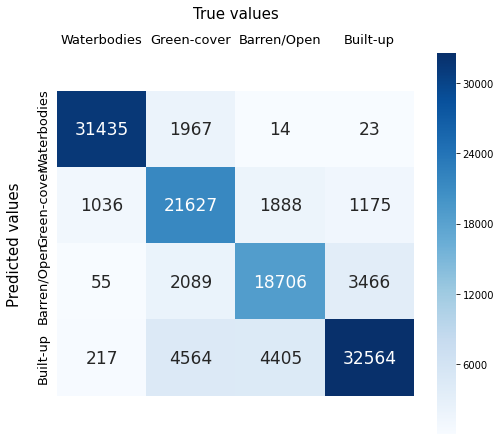

In [30]:
class_lables = ['Waterbodies', 'Green-cover', 'Barren/Open', 'Built-up']
import seaborn as sn
plt.figure(figsize = (8,7))
ax = sn.heatmap(cm[1:,1:], xticklabels=class_lables, yticklabels=class_lables, annot=True, fmt='g', cmap="Blues", annot_kws={"fontsize":17}, cbar=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=13, labelbottom = False, labeltop=True, left=False, bottom=False)
plt.yticks(va='center')
plt.ylabel('Predicted values', fontsize=15, labelpad = 15)
plt.xlabel('True values', fontsize=15, labelpad = 15)
ax.xaxis.set_label_position('top')

from sklearn.metrics import cohen_kappa_score
kappa_land = cohen_kappa_score(y_pred_land, ytest_land)
print(kappa_land)

In [31]:
np.set_printoptions(formatter={'float_kind':'{0:0.4f}'.format})
LULC_prop = np.zeros([np.shape(maps)[0], 5])
pred_prop = np.zeros([1, 5])
for p in range(5):
    for k in range(np.shape(maps)[0]):
        LULC_prop[k,p] = (np.sum(maps[k]==p*17)/(np.shape(maps)[1]*np.shape(maps)[2]))*100
    pred_prop[0,p] = (np.sum(pred_2008==p*17)/(np.shape(maps)[1]*np.shape(maps)[2]))*100
print(LULC_prop)
print(pred_prop)

[[1.5055 32.4656 19.1672 28.5242 17.6797]
 [1.3000 27.4234 20.7695 27.1266 22.5172]
 [1.0672 27.1164 21.6203 23.2969 25.8031]
 [0.8234 26.7383 20.5188 22.2609 28.3187]
 [0.7547 25.5805 23.6305 19.5414 29.0844]]
[[0.7547 26.1242 20.0984 18.9969 32.6172]]


(-0.5, 319.5, 399.5, -0.5)

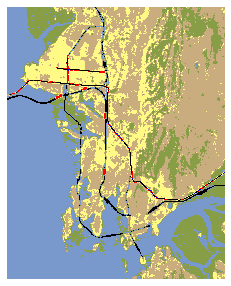

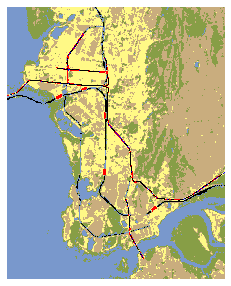

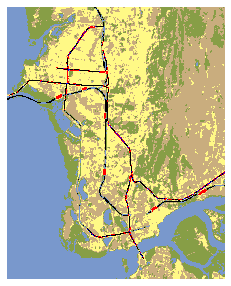

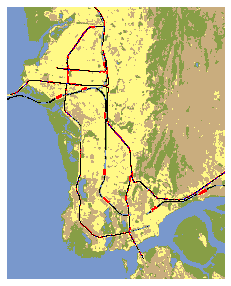

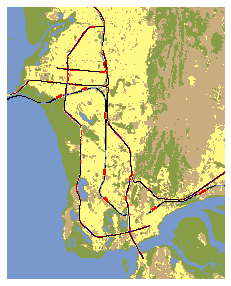

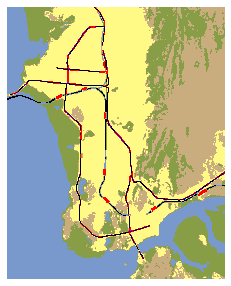

In [32]:
for i in range(5):
    plt.figure(figsize=(4,5))
    plt.imshow(maps[i], cmap_new)
    plt.grid(None)
    plt.axis('off')

plt.figure(figsize=(4,5))
plt.imshow(pred_2008, cmap_new)
plt.grid(None)
plt.axis('off')

#plt.imsave('D:/urban growth models/Final presentation/Actual_2008.png', maps[-1], dpi=900, cmap = cmap_new)
#plt.imsave('D:/urban growth models/Final presentation/Predicted_2008.png', pred_2008, dpi=900, cmap = cmap_new)

In [ ]:
plt.imsave('D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/Other maps/Actual_1988.png', maps[0], dpi=900, cmap = cmap_new)
plt.imsave('D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/Other maps/Actual_1993.png', maps[1], dpi=900, cmap = cmap_new)
plt.imsave('D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/Other maps/Actual_1998.png', maps[2], dpi=900, cmap = cmap_new)
plt.imsave('D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/Other maps/Actual_2003.png', maps[3], dpi=900, cmap = cmap_new)
plt.imsave('D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/Other maps/Actual_2008.png', maps[4], dpi=900, cmap = cmap_new)
plt.imsave('D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/Other maps/Predicted_2008.png', pred_2008, dpi=900, cmap = cmap_new)

changes for Virar: [[1.8267 0.0000 12.7256 46.6585 37.1965]
 [1.8267 0.0000 11.6730 39.3796 45.5280]
 [1.8267 0.0000 11.2553 36.7342 48.5910]
 [1.8267 0.0000 10.7039 34.3172 51.5594]
 [1.8267 0.0000 10.3252 32.6465 53.6088]]
changes for Boisar: [[0.7574 0.2729 37.4582 33.2535 27.0216]
 [0.7574 0.0056 36.8846 28.4250 32.6910]
 [0.7574 0.0000 35.0579 25.7184 37.2299]
 [0.7574 0.0000 33.9051 23.7191 40.3820]
 [0.7574 0.0000 33.0196 21.9648 43.0218]]
changes for Vapi: [[0.9802 2.5562 11.7342 52.5785 29.4776]
 [0.9802 0.6126 12.9316 46.7365 36.0659]
 [0.9802 0.0557 13.0931 42.6988 40.4990]
 [0.9802 0.0278 12.6030 39.0622 44.6536]
 [0.9802 0.0111 12.3691 35.7207 48.2457]]
changes for Billimora: [[0.8131 2.9127 15.7942 66.9804 11.8790]
 [0.8131 0.8354 17.4816 65.3208 13.9285]
 [0.8131 0.4678 17.7601 63.4384 15.9000]
 [0.8131 0.4177 17.7768 61.8011 17.5707]
 [0.8131 0.3676 17.7545 60.2751 19.1691]]
changes for Surat: [[1.1417 4.8396 54.4498 17.9439 19.0354]
 [1.1417 0.2952 58.5487 13.2156 24.2

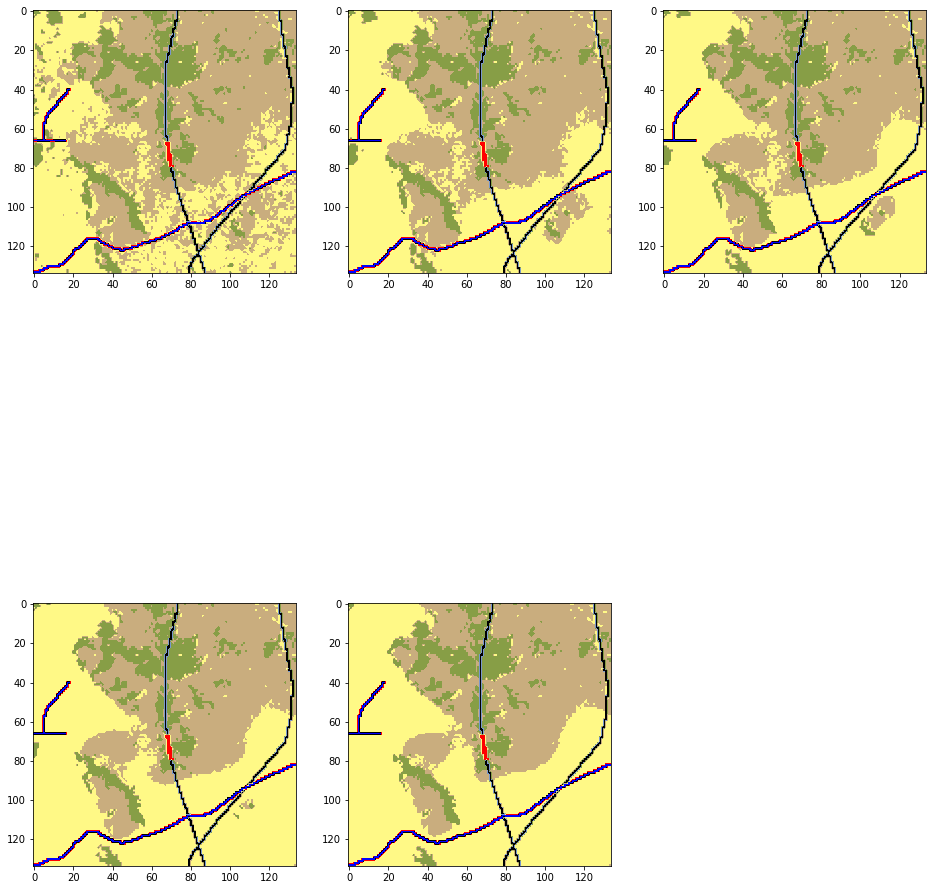

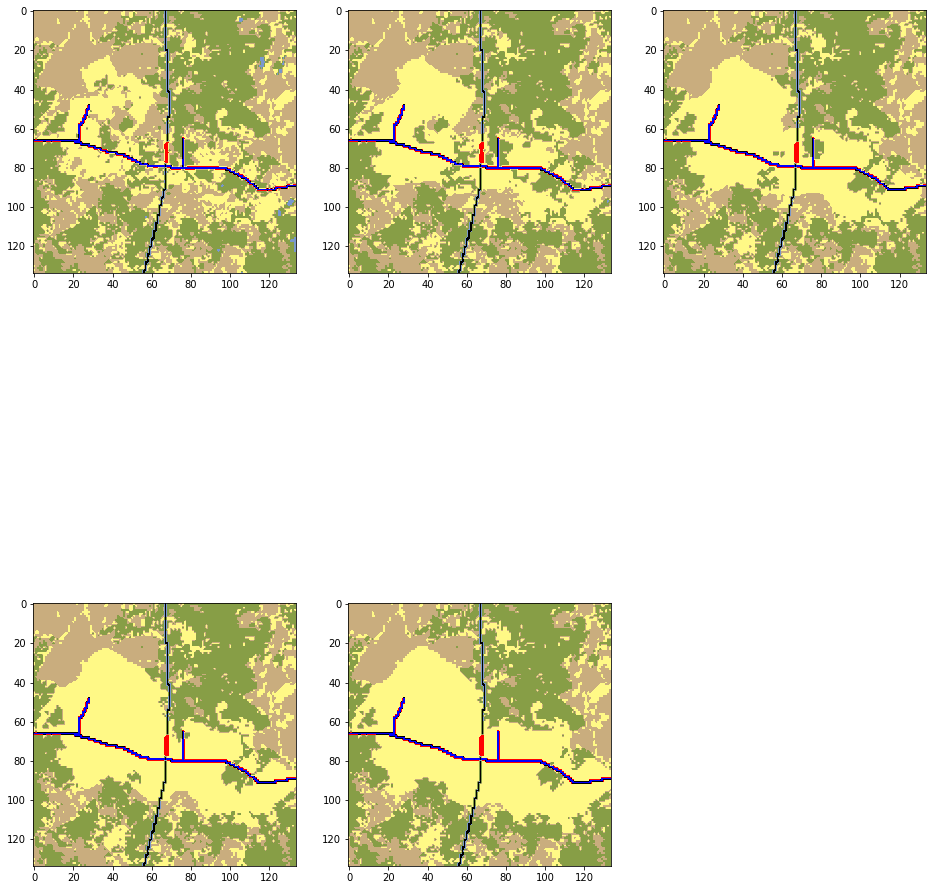

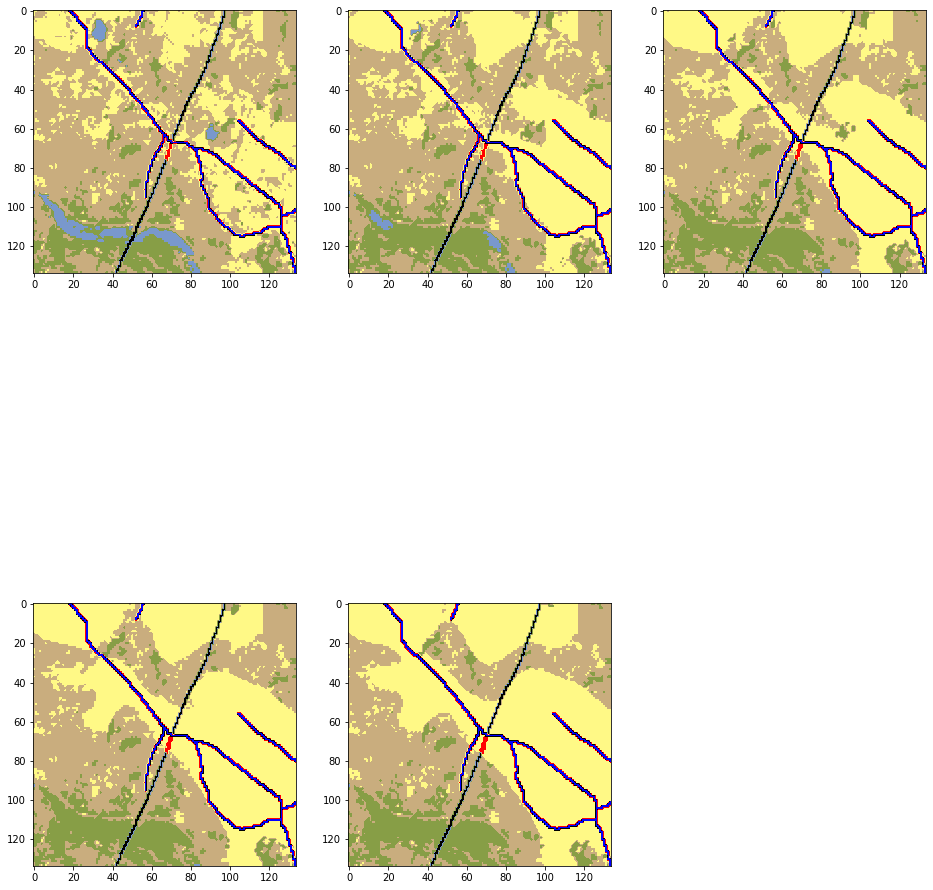

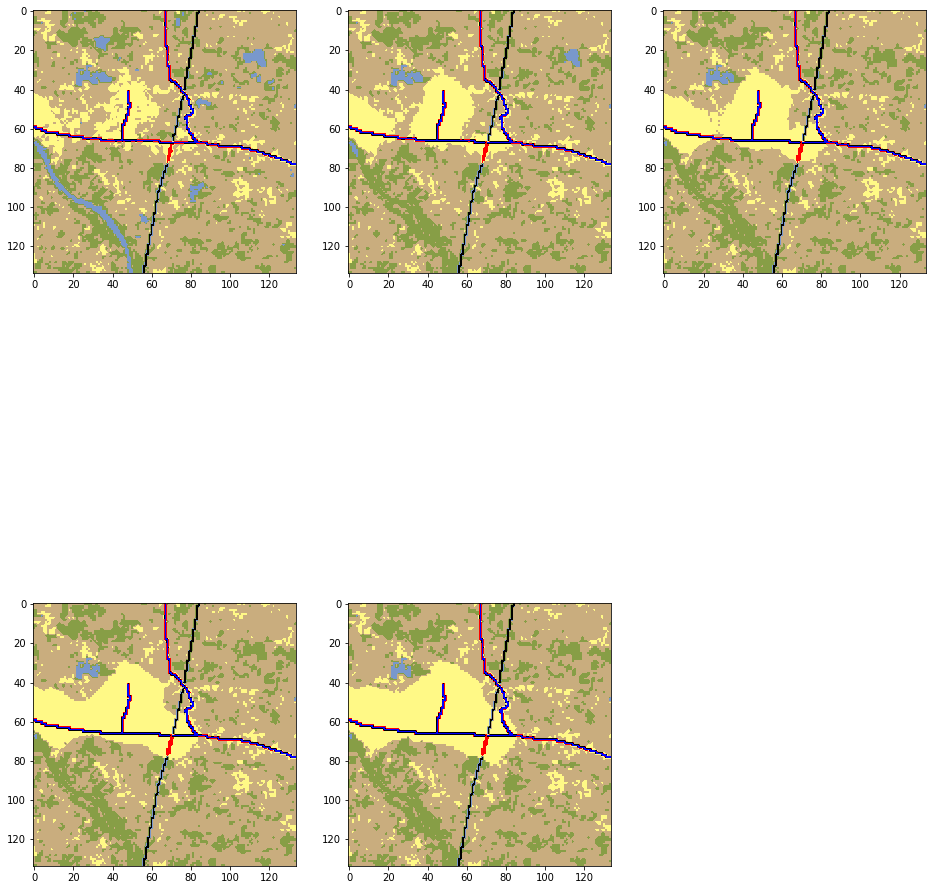

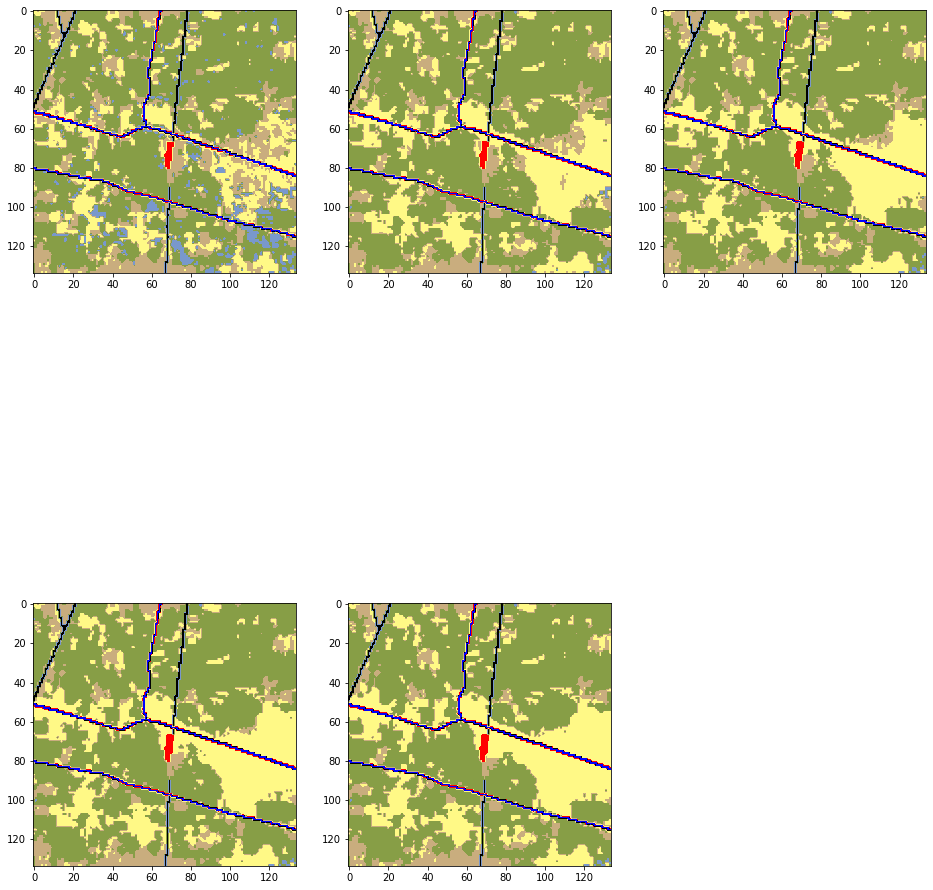

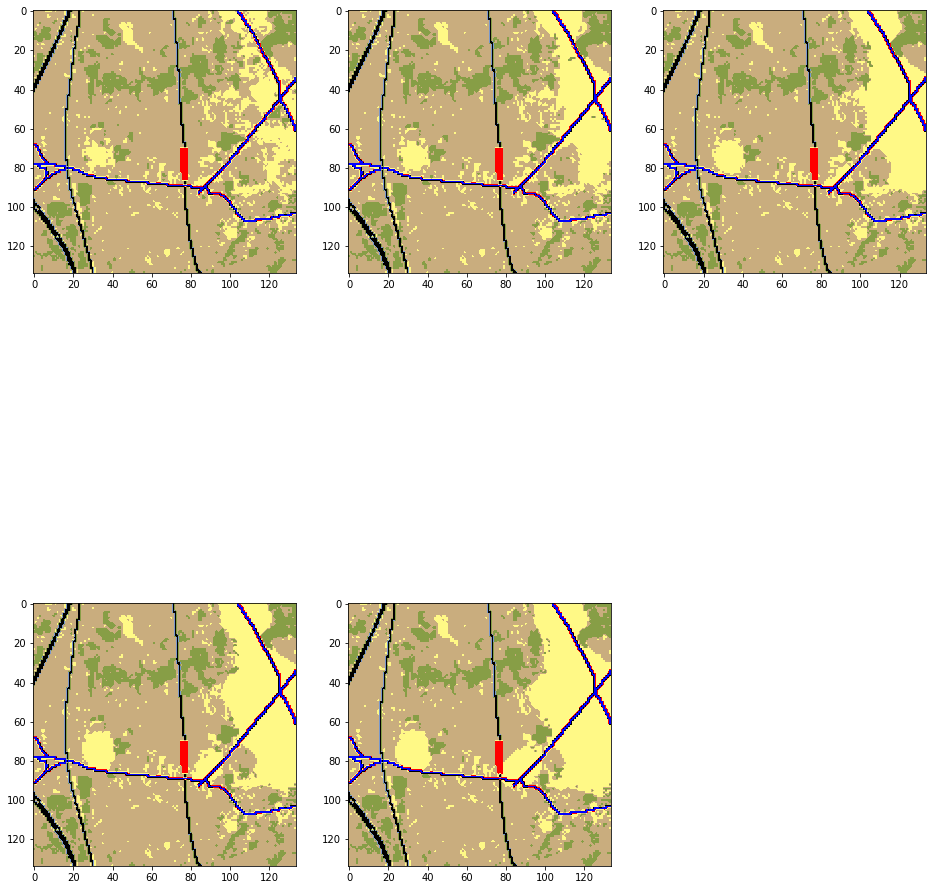

In [69]:
# with station

start_year = 2022
stations = ['Virar', 'Boisar', 'Vapi', 'Billimora', 'Surat', 'Bharuch']

ymin = 100
ymax = 234
xmin = 100
xmax = 234

All_maps = np.empty(np.append(np.shape(stations), [5,(ymax-ymin),(xmax-xmin)]))

Barren_near_stn = np.zeros([6, 5])
path = 'D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/'

for station_name in stations:
    maps_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_LULC.tif'))
    roads_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_roads.tif'))
    stn_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_HSR_stn.tif'))

    maps = [maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax]]
    roads = [roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax]]
    station = [stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax]]

    rails = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_rail.tif'))
    DEM = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_DEM.tif'))[1:-1,1:-1]
    slope = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_slope.tif'))[1:-1,1:-1]
    elevations = np.empty(np.shape(maps))
    gradient = np.empty(np.shape(maps))

    all_roads = np.copy(roads[-1])
    all_stn = np.copy(station[-1])
    for i in range(np.shape(maps)[0]):
        maps[i][rails[ymin:ymax, xmin:xmax]==102] = 0
        maps[i][all_stn==85] = 0
        maps[i][station[i]==85] = 85
        maps[i][all_roads==119] = 0
        maps[i][roads[i]==119] = 119
        elevations[i] = DEM[ymin:ymax, xmin:xmax]
        gradient[i] = slope[ymin:ymax, xmin:xmax]

    LULC_prop = np.zeros([5, 5])
    for p in range(5):
        LULC_prop[0][p] = (np.sum(maps[0]==p*17)/(np.shape(maps)[1]*np.shape(maps)[2]))*100
    
    for i in range(1,5):
        neighbourhood_size = 15
        id_all = np.array([[1],[2],[3],[4]])
        d_max = (np.sqrt((ymax-ymin)**2 + (xmax-xmin)**2))*0.03
        stn_dist = np.ones(np.shape(station))*d_max
        stn_dist = distance_calculator(station, 85, 30, stn_dist)
        road_dist = np.ones(np.shape(roads))*d_max
        road_dist = distance_calculator(roads, 119, 30, road_dist)

        [self_water, self_green, self_barren, self_builtup, self_road] = intrinsic_values(maps, [17,34,51,68,119])
        [neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_road], neighbourhood_size)

        X1 = prepare_data(self_water[i-1:i])
        X2 = prepare_data(self_green[i-1:i])
        X3 = prepare_data(self_barren[i-1:i])
        X4 = prepare_data(self_builtup[i-1:i])
        X5 = prepare_data(neighbour_water[i-1:i])
        X6 = prepare_data(neighbour_green[i-1:i])
        X7 = prepare_data(neighbour_barren[i-1:i])
        X8 = prepare_data(neighbour_builtup[i-1:i])
        X9 = prepare_data(neighbour_road[i-1:i])
        X_stn = prepare_data(stn_dist[i-1:i])
        X10 = np.zeros(np.shape(X_stn))
        X10[X_stn<=0.25] = 1
        X_stn[X_stn<=0.25] = d_max
        X11 = np.zeros(np.shape(X_stn))
        X11[X_stn<=0.5] = 1
        X_stn[X_stn<=0.5] = d_max
        X12 = np.zeros(np.shape(X_stn))
        X12[X_stn<=1] = 1
        X_stn[X_stn<=1] = d_max
        X13 = np.zeros(np.shape(X_stn))
        X13[X_stn<=2] = 1
        X_stn[X_stn<=2] = d_max

        X_road = prepare_data(road_dist[i-1:i])
        X14 = np.zeros(np.shape(X_road))
        X14[X_road<=0.125] = 1
        X_road[X_road<=0.125] = d_max
        X15 = np.zeros(np.shape(X_road))
        X15[X_road<=0.25] = 1
        X_road[X_road<=0.25] = d_max
        X16 = np.zeros(np.shape(X_road))
        X16[X_road<=0.5] = 1
        X_road[X_road<=0.5] = d_max
        X17 = np.zeros(np.shape(X_road))
        X17[X_road<=1] = 1
        X_road[X_road<=1] = d_max

        X18 = prepare_data(gradient[i-1:i])
        X18[X18<=5] = 1
        X18[X18>5] = 0
        X19 = prepare_data(elevations[i-1:i])
        X19 = X19/100
        X0 = np.ones(np.shape(X1))

        xcheck = np.transpose([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19])

        check_X = xcheck[:,1] + xcheck[:,2] + xcheck[:,3] + xcheck[:,4]
        index = np.where(check_X==0)
        xcheck[[index],:] = 0

        y_pred = classifier_land.predict(xcheck)
        map_new = np.reshape(y_pred,[(ymax-ymin),(xmax-xmin)])
        map_new[maps[i-1]==119] = 7
        map_new[all_stn==85] = 5
        #map_new[maps[i-1]==17] = 1
        map_new[maps[i-1]==68] = 4
        map_new = map_new*17
        maps[i] = map_new
        
        for p in range(5):
            LULC_prop[i][p] = (np.sum(maps[i]==p*17)/(np.shape(maps)[1]*np.shape(maps)[2]))*100

    print('changes for '+station_name +':', LULC_prop)
    
    All_maps[stations.index(station_name)] = maps
    
    path = 'D:/GIS/Greenfield_HSR_stn/Projected_maps/'
    fig = plt.figure(figsize=(16,20))
    for i in range(5):
        fig.add_subplot(2,3,i+1)
        plt.imshow(maps[i], cmap_new)
        plt.imsave(path+'with_'+str(station_name)+'_'+str(start_year+5*i)+'.png', maps[i], dpi=900, cmap = cmap_new)


changes for Virar: [[1.8267 0.0000 12.7256 46.6585 37.1965]
 [1.8267 0.0000 11.2664 40.8777 44.4364]
 [1.8267 0.0000 10.7262 38.7558 47.0985]
 [1.8267 0.0000 9.9800 37.4192 49.1813]
 [1.8267 0.0000 9.7071 36.1383 50.7351]]
changes for Boisar: [[0.7574 0.2729 37.4582 33.2535 27.0216]
 [0.7574 0.0167 36.8512 30.3130 30.8254]
 [0.7574 0.0111 35.7596 28.4250 33.8104]
 [0.7574 0.0056 34.8519 27.1998 35.9490]
 [0.7574 0.0000 33.8661 26.0247 38.1154]]
changes for Vapi: [[0.9802 2.5562 11.7342 52.5785 29.4776]
 [0.9802 1.5148 11.7621 48.5075 34.5623]
 [0.9802 1.0526 11.7064 46.1963 37.3914]
 [0.9802 0.7908 11.6340 44.2192 39.7026]
 [0.9802 0.5124 11.4391 42.4259 41.9693]]
changes for Billimora: [[0.8131 2.9127 15.7942 66.9804 11.8790]
 [0.8131 1.6596 16.0559 66.7966 13.0541]
 [0.8131 1.1974 16.1116 66.3901 13.8672]
 [0.8131 1.0192 16.0225 65.7218 14.8029]
 [0.8131 0.9913 15.9055 65.0312 15.6382]]
changes for Surat: [[1.1417 4.8396 54.4498 17.9439 19.0354]
 [1.1417 0.8966 57.6576 15.1593 22.555

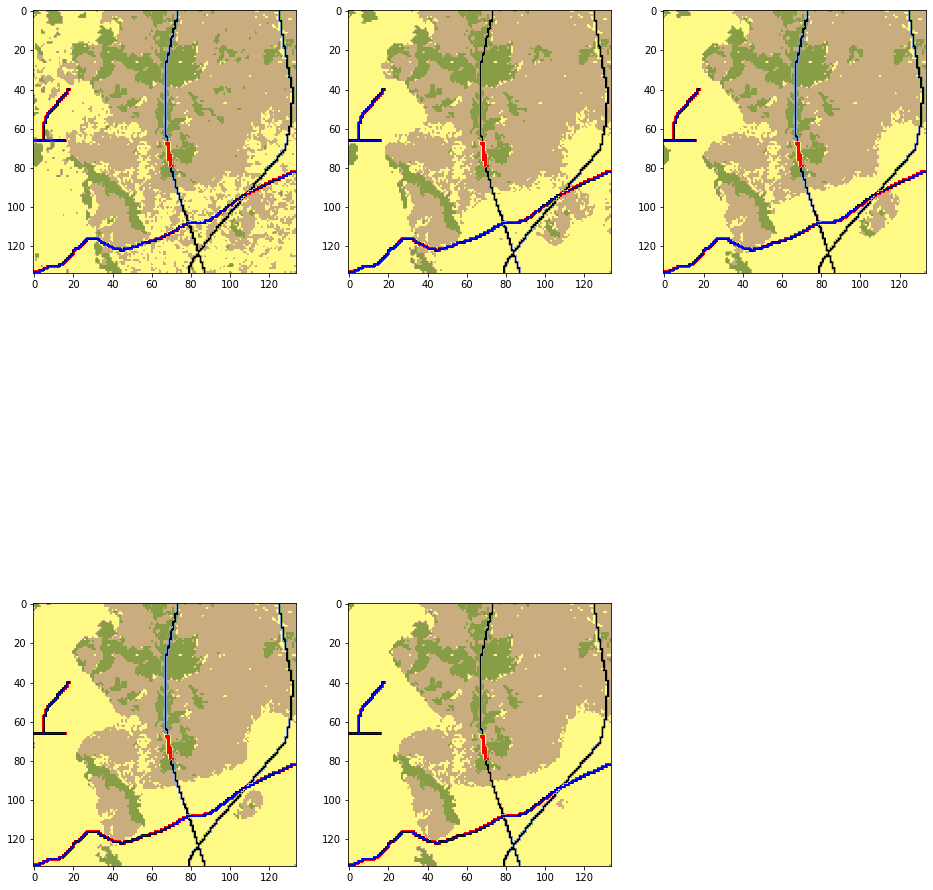

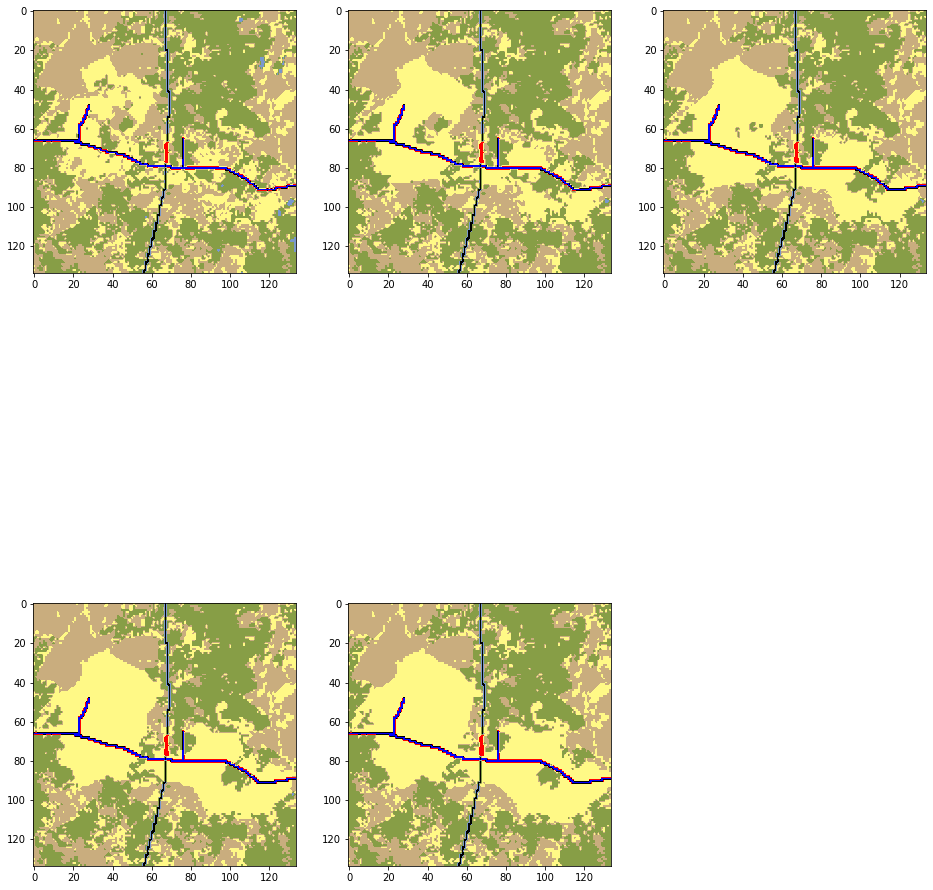

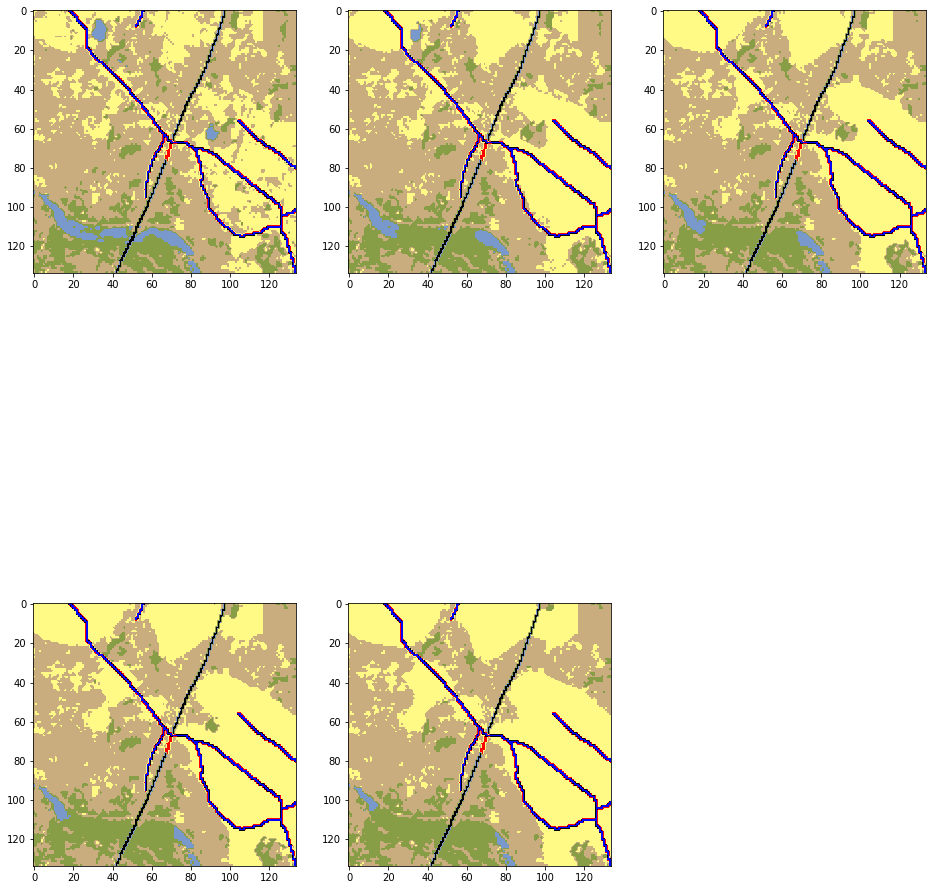

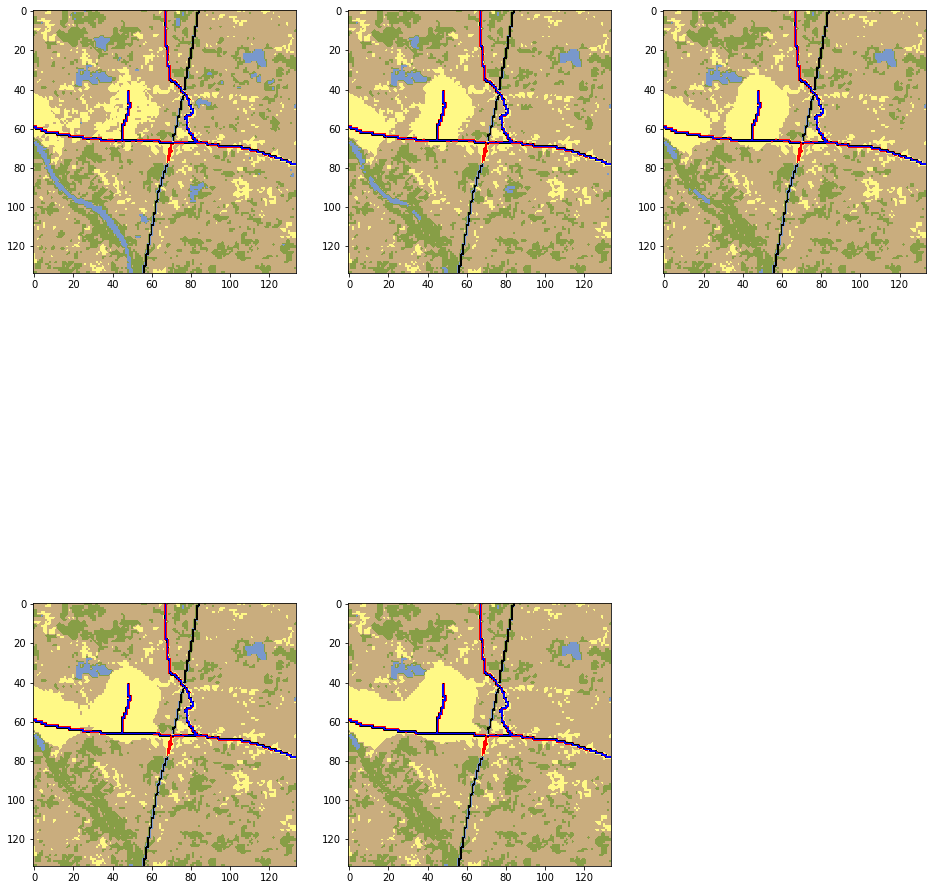

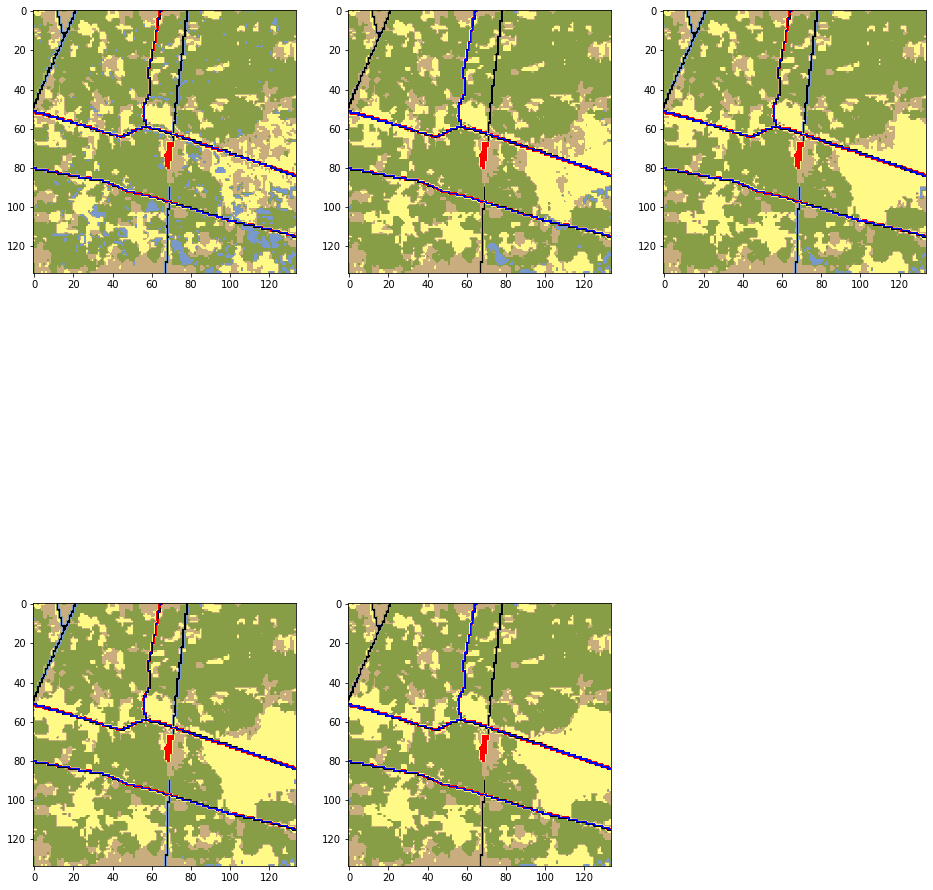

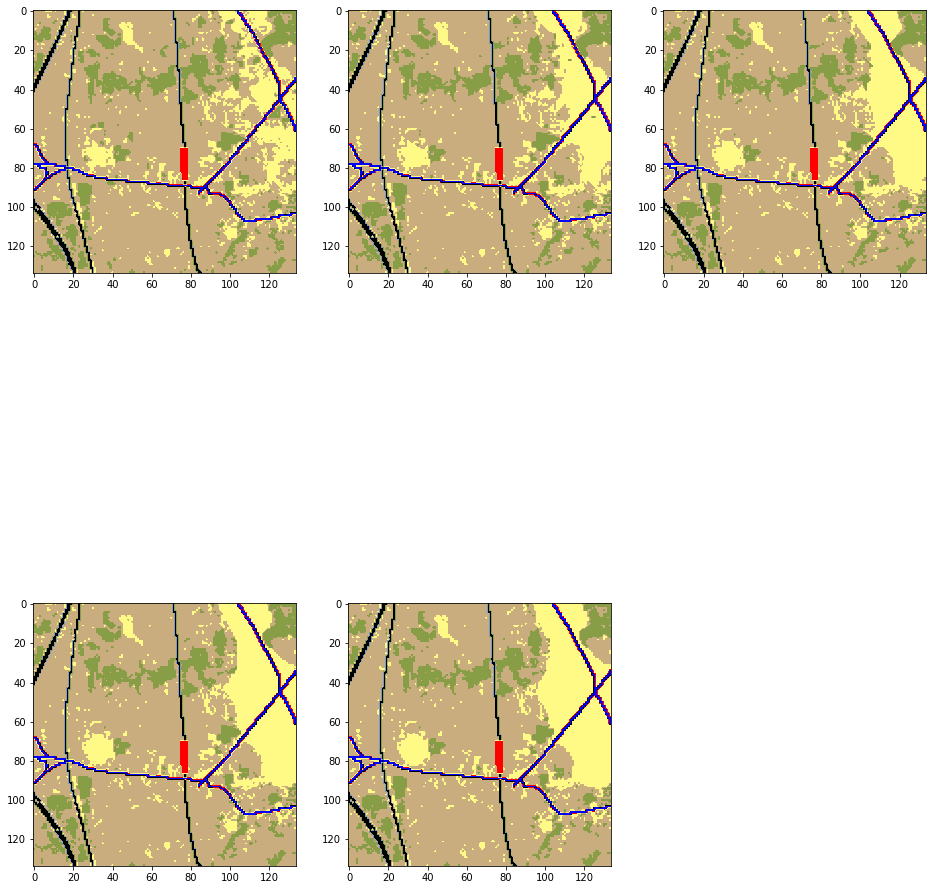

In [35]:
# without_station

start_year = 2022
stations = ['Virar', 'Boisar', 'Vapi', 'Billimora', 'Surat', 'Bharuch']

ymin = 100
ymax = 234
xmin = 100
xmax = 234
plt.rcParams['figure.max_open_warning'] = 0

Barren_near_stn = np.zeros([6, 5])
path = 'D:/GIS/Greenfield_HSR_stn/Projected_maps/20_yr_maps_new/'

for station_name in stations:
    maps_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_LULC.tif'))
    roads_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_roads.tif'))
    stn_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_HSR_stn.tif'))

    maps = [maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax], maps_2022[ymin:ymax, xmin:xmax]]
    roads = [roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax], roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax], roads_2022[ymin:ymax, xmin:xmax]]
    station = [stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax], stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax], stn_2022[ymin:ymax, xmin:xmax]]

    rails = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_rail.tif'))
    DEM = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_DEM.tif'))[1:-1,1:-1]
    slope = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_slope.tif'))[1:-1,1:-1]
    elevations = np.empty(np.shape(maps))
    gradient = np.empty(np.shape(maps))

    all_roads = np.copy(roads[-1])
    all_stn = np.copy(station[-1])
    for i in range(np.shape(maps)[0]):
        maps[i][rails[ymin:ymax, xmin:xmax]==102] = 0
        maps[i][all_stn==85] = 0
        maps[i][station[i]==85] = 85
        maps[i][all_roads==119] = 0
        maps[i][roads[i]==119] = 119
        elevations[i] = DEM[ymin:ymax, xmin:xmax]
        gradient[i] = slope[ymin:ymax, xmin:xmax]

    LULC_prop = np.zeros([5, 5])
    for p in range(5):
        LULC_prop[0][p] = (np.sum(maps[0]==p*17)/(np.shape(maps)[1]*np.shape(maps)[2]))*100

    for i in range(1,5):
        neighbourhood_size = 15
        id_all = np.array([[1],[2],[3],[4]])
        d_max = (np.sqrt((ymax-ymin)**2 + (xmax-xmin)**2))*0.03
        stn_dist = np.zeros(np.shape(station))
        #stn_dist = distance_calculator(station, 85, 30, stn_dist)
        road_dist = np.ones(np.shape(roads))*d_max
        road_dist = distance_calculator(roads, 119, 30, road_dist)

        [self_water, self_green, self_barren, self_builtup, self_road] = intrinsic_values(maps, [17,34,51,68,119])
        [neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_road], neighbourhood_size)

        X1 = prepare_data(self_water[i-1:i])
        X2 = prepare_data(self_green[i-1:i])
        X3 = prepare_data(self_barren[i-1:i])
        X4 = prepare_data(self_builtup[i-1:i])
        X5 = prepare_data(neighbour_water[i-1:i])
        X6 = prepare_data(neighbour_green[i-1:i])
        X7 = prepare_data(neighbour_barren[i-1:i])
        X8 = prepare_data(neighbour_builtup[i-1:i])
        X9 = prepare_data(neighbour_road[i-1:i])
        X_stn = prepare_data(stn_dist[i-1:i])
        X10 = np.zeros(np.shape(X_stn))
        #X10[X_stn<=0.25] = 1
        X11 = np.zeros(np.shape(X_stn))
        #X11[X_stn<=0.5] = 1
        X12 = np.zeros(np.shape(X_stn))
        #X12[X_stn<=1] = 1
        X13 = np.zeros(np.shape(X_stn))
        #X13[X_stn<=2] = 1

        X_road = prepare_data(road_dist[i-1:i])
        X14 = np.zeros(np.shape(X_road))
        X14[X_road<=0.125] = 1
        X_road[X_road<=0.125] = d_max
        X15 = np.zeros(np.shape(X_road))
        X15[X_road<=0.25] = 1
        X_road[X_road<=0.25] = d_max
        X16 = np.zeros(np.shape(X_road))
        X16[X_road<=0.5] = 1
        X_road[X_road<=0.5] = d_max
        X17 = np.zeros(np.shape(X_road))
        X17[X_road<=1] = 1
        X_road[X_road<=1] = d_max

        X18 = prepare_data(gradient[i-1:i])
        X18[X18<=5] = 1
        X18[X18>5] = 0
        X19 = prepare_data(elevations[i-1:i])
        X19 = X19/100
        X0 = np.ones(np.shape(X1))

        xcheck = np.transpose([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19])

        check_X = xcheck[:,1] + xcheck[:,2] + xcheck[:,3] + xcheck[:,4]
        index = np.where(check_X==0)
        xcheck[[index],:] = 0

        y_pred = classifier_land.predict(xcheck)
        map_new = np.reshape(y_pred,[(ymax-ymin),(xmax-xmin)])
        map_new[maps[i-1]==119] = 7
        map_new[all_stn==85] = 5
        #map_new[maps[i-1]==17] = 1
        map_new[maps[i-1]==68] = 4
        map_new = map_new*17
        maps[i] = map_new
        
        for p in range(5):
            LULC_prop[i][p] = (np.sum(maps[i]==p*17)/(np.shape(maps)[1]*np.shape(maps)[2]))*100

    print('changes for '+station_name +':', LULC_prop)
    
    path = 'D:/GIS/Greenfield_HSR_stn/Projected_maps/'
    fig = plt.figure(figsize=(16,20))
    for i in range(5):
        fig.add_subplot(2,3,i+1)
        plt.imshow(maps[i], cmap_new)
        plt.imsave(path+'without_'+str(station_name)+'_'+str(start_year+5*i)+'.png', maps[i], dpi=900, cmap = cmap_new)


In [36]:
start_year = 2022
stations = ['Virar', 'Boisar', 'Vapi', 'Billimora', 'Surat', 'Bharuch']

distances = np.zeros(np.shape(stations)[0])

for station_name in stations:
    maps_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_LULC.tif'))[ymin:ymax, xmin:xmax]
    roads_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_roads.tif'))[ymin:ymax, xmin:xmax]
    stn_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_HSR_stn.tif'))[ymin:ymax, xmin:xmax]
    rails = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_rail.tif'))[ymin:ymax, xmin:xmax]
    maps_2022[stn_2022==85] = 85
    maps_2022[rails==102] = 102
    maps_2022[roads_2022==119] = 119
    [X_mean, Y_mean] = np.mean(np.where(all_stn==85),1)
    BUA = np.transpose(np.where(maps_2022==68))
    distance = np.sqrt(np.sum(np.square(BUA - [X_mean, Y_mean]),1))*0.03
    distances[stations.index(station_name)] = np.mean(distance)

print('distance' , distances)

distance [1.7818 1.4251 1.5932 1.4887 1.5164 1.5451]


In [71]:
years = [1988, 1993, 1998, 2003, 2008]
LULCs = ['water', 'green', 'barren', 'builtup', 'roads']
for i in years:
    globals()['maps_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/LULC/'+str(i)+'.tif'))
    globals()['roads_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_road_modified.tif'))
    globals()['stn_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_stn.tif'))
    
rail_line = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/rail_line.tif'))
DEM = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_DEM.tif'))[1:-1,1:-1]
slope = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_slope.tif'))[1:-1,1:-1]
height = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Vashi_height_modified_new2.tif'))
height[height==0] = 100
height = height//10 + 1
height[height == 3] = 2
height[height==11] = 0
height[height>3] = 3

ymin = 547
ymax = 615
xmin = 35
xmax = 103

Vashi_maps = [maps_1988[ymin:ymax, xmin:xmax], maps_1993[ymin:ymax, xmin:xmax], maps_1998[ymin:ymax, xmin:xmax], maps_2003[ymin:ymax, xmin:xmax], maps_2008[ymin:ymax, xmin:xmax]]
Vashi_roads = [roads_1988[ymin:ymax, xmin:xmax], roads_1993[ymin:ymax, xmin:xmax], roads_1998[ymin:ymax, xmin:xmax], roads_2003[ymin:ymax, xmin:xmax], roads_2008[ymin:ymax, xmin:xmax]]
Vashi_stations = [stn_1988[ymin:ymax, xmin:xmax], stn_1993[ymin:ymax, xmin:xmax], stn_1998[ymin:ymax, xmin:xmax], stn_2003[ymin:ymax, xmin:xmax], stn_2008[ymin:ymax, xmin:xmax]]
Vashi_elevations = np.empty(np.shape(Vashi_maps))
Vashi_gradient = np.empty(np.shape(Vashi_maps))
Vashi_building_height = np.empty(np.shape(Vashi_maps))
Vashi_rails = rail_line[ymin:ymax, xmin:xmax]
Vashi_all_roads = np.copy(Vashi_roads[-1])
Vashi_all_stn = np.copy(Vashi_stations[-1])

for i in range(np.shape(Vashi_maps)[0]):
    Vashi_maps[i][Vashi_rails==102] = 0
    Vashi_maps[i][Vashi_all_stn==85] = 0
    Vashi_maps[i][Vashi_stations[i]==85] = 85
    Vashi_maps[i][Vashi_all_roads==119] = 0
    Vashi_maps[i][Vashi_roads[i]==119] = 119
    Vashi_elevations[i] = DEM[ymin:ymax, xmin:xmax]
    Vashi_gradient[i] = slope[ymin:ymax, xmin:xmax]
    Vashi_building_height[i] = np.multiply(height[ymin:ymax, xmin:xmax],Vashi_maps[i]==68)
    

In [72]:
neighbourhood_size = 15
id_all = np.array([[1],[2],[3],[4]])
d_max = 16

# proximity variables
stn_dist = np.ones(np.shape(Vashi_stations))*d_max
stn_dist = distance_calculator(Vashi_stations, 85, 30, stn_dist)
road_dist = np.ones(np.shape(Vashi_roads))*d_max
road_dist = distance_calculator(Vashi_roads, 119, 30, road_dist)

[self_water, self_green, self_barren, self_builtup, self_stn, self_road] = intrinsic_values(Vashi_maps, [17,34,51,68,85,119])
[neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_stn, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_stn, self_road], neighbourhood_size)

[self_low, self_mid, self_high] = intrinsic_values(Vashi_building_height, [1,2,3])
[neighbour_low, neighbour_mid, neighbour_high] = Cellular_Automata([self_low, self_mid, self_high], neighbourhood_size//3)

In [73]:
X_main = prepare_data(neighbour_builtup[0:4])

X6 = prepare_data(neighbour_low[0:4])
X7 = prepare_data(neighbour_mid[0:4])
X8 = prepare_data(neighbour_high[0:4])
X9 = prepare_data(neighbour_road[0:4])

X_stn = prepare_data(stn_dist[0:4])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1

X_road = prepare_data(road_dist[0:4])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1

X18 = prepare_data(Vashi_gradient[0:4])
X18[X18<=5] = 1
X18[X18>5] = 0
X19 = prepare_data(Vashi_elevations[0:4])
X19 = X19/100

X0 = np.ones(np.shape(X10))

Y1 = prepare_data(self_water[1:5])
Y2 = prepare_data(self_green[1:5])
Y3 = prepare_data(self_barren[1:5])
Y4 = prepare_data(self_builtup[1:5])
ytrain = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

# xtrain_h = np.transpose([X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,ytrain])
xtrain_h = np.transpose([X0,X_main,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17])
ytrain_h = prepare_data(Vashi_building_height[1:5])
xtrain_h[ytrain_h==0,:] = 0

In [74]:
%%time
np.set_printoptions(formatter={'float_kind':'{0:0.3f}'.format})
classifier_height = LogisticRegression(solver='lbfgs', random_state = 0, max_iter = 10000, multi_class='ovr')
classifier_height.fit(xtrain_h, ytrain_h)
weights_height = classifier_height.coef_
print(weights_height[1:,:])

[[4.308 0.677 8.790 -5.005 -3.078 -1.386 0.502 0.766 0.687 2.353 1.805
  1.014 1.263 0.895]
 [5.073 0.226 -5.513 5.070 -6.637 0.999 1.943 1.807 1.829 -0.505 0.841
  1.176 1.219 1.601]
 [5.507 -0.522 -5.938 -3.490 8.563 0.069 1.356 1.441 1.535 1.174 -0.111
  0.267 0.128 -0.179]]
Wall time: 207 ms


In [75]:
X_main = prepare_data(neighbour_builtup[3:4])

X6 = prepare_data(neighbour_low[3:4])
X7 = prepare_data(neighbour_mid[3:4])
X8 = prepare_data(neighbour_high[3:4])
X9 = prepare_data(neighbour_road[3:4])

X_stn = prepare_data(stn_dist[3:4])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1

X_road = prepare_data(road_dist[3:4])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1

X18 = prepare_data(Vashi_gradient[3:4])
X18[X13<=5] = 1
X18[X13>5] = 0
X19 = prepare_data(Vashi_elevations[3:4])
X19 = X19/100

X0 = np.ones(np.shape(X10))

Y1 = prepare_data(self_water[4:5])
Y2 = prepare_data(self_green[4:5])
Y3 = prepare_data(self_barren[4:5])
Y4 = prepare_data(self_builtup[4:5])
ytest = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

# xtest_h = np.transpose([X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,ytest])
xtest_h = np.transpose([X0,X_main,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17])
ytest_h = prepare_data(Vashi_building_height[4:5]).ravel()
xtest_h[ytest_h==0,:] = 0

In [76]:
%%time
np.set_printoptions(formatter={'float_kind':'{0:0.4f}'.format})
ypred_h = classifier_height.predict(xtest_h)
cm_height = confusion_matrix(ypred_h, ytest_h)
print(cm_height)

acc_height = accuracy_score(ypred_h, ytest_h)
print(acc_height)
acu_height = (cm_height[1,1] + cm_height[2,2] + cm_height[3,3])/np.sum(cm_height[1:,1:])
print(acu_height)

[[3388    0    0    0]
 [   0  407   21   21]
 [   0   34  507   90]
 [   0    4   31  121]]
0.9565311418685121
0.837378640776699
Wall time: 8.95 ms


0.9002132893913812
Wall time: 58.9 ms


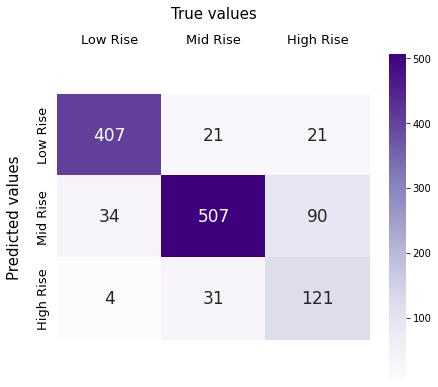

In [77]:
%%time
class_lables = ['Low Rise', 'Mid Rise', 'High Rise']
import seaborn as sn
plt.figure(figsize = (7,6))
ax = sn.heatmap(cm_height[1:,1:], xticklabels=class_lables, yticklabels=class_lables, annot=True, fmt='g', cmap="Purples", annot_kws={"fontsize":17}, cbar=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=13, labelbottom = False, labeltop=True, left=False, bottom=False)
plt.yticks(va='center')
plt.ylabel('Predicted values', fontsize=15, labelpad = 15)
plt.xlabel('True values', fontsize=15, labelpad = 15)
ax.xaxis.set_label_position('top')

from sklearn.metrics import cohen_kappa_score
kappa_height = cohen_kappa_score(ypred_h, ytest_h)
print(kappa_height)

Virar
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
changes for Virar: [[62.8035 37.1965 0.0000 0.0000]
 [53.1689 44.8485 0.2450 0.1448]
 [50.1726 47.6888 0.4010 0.1448]
 [47.2878 50.2618 0.7129 0.1448]
 [45.2551 51.7097 1.2976 0.1448]]
Boisar
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
changes for Boisar: [[72.9784 27.0216 0.0000 0.0000]
 [67.0027 30.9813 0.7296 0.0501]
 [62.4638 34.5233 1.7264 0.0501]
 [59.3117 36.8233 2.5785 0.0501]
 [56.6719 38.7948 3.2468 0.0501]]
Vapi
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
changes for Vapi: [[70.5224 29.4776 0.0000 0.0000]
 [61.3722 35.4756 0.4511 0.0278]
 [56.9837 39.0454 1.2698 0.0278]
 [52.9684 42.0862 2.2444 0.0278]
 [49.5043 44.8318 2.9350 0.0557]]
Billimora
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
(17956, 15)
changes for Billimora: [[88.1210 

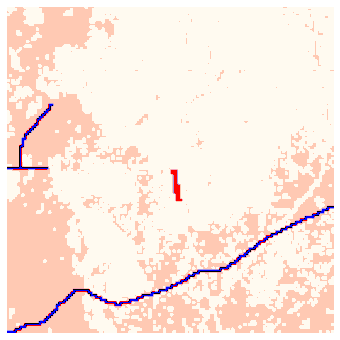

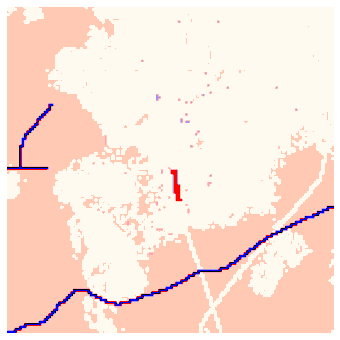

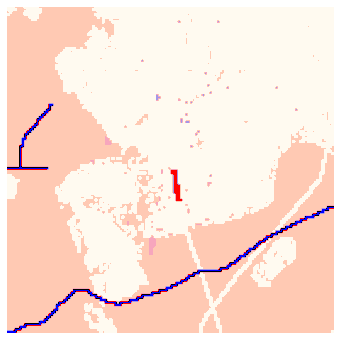

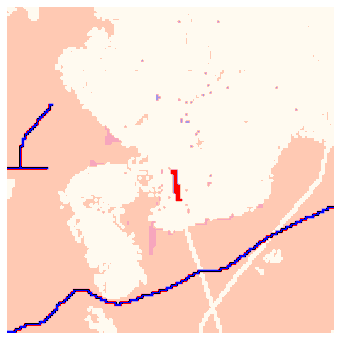

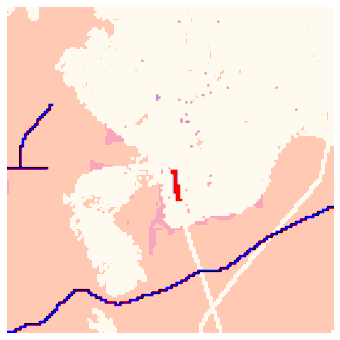

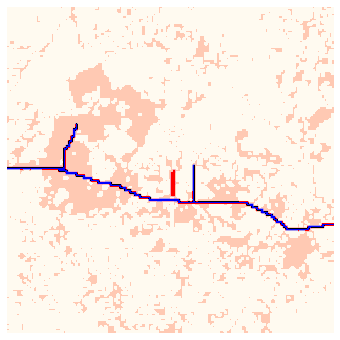

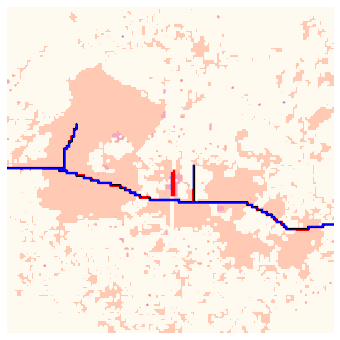

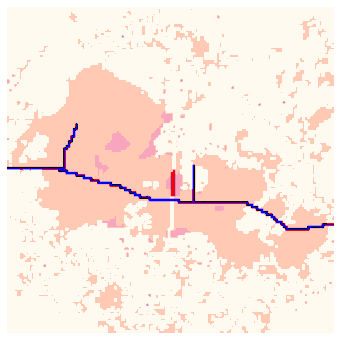

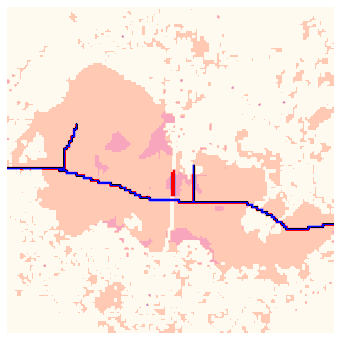

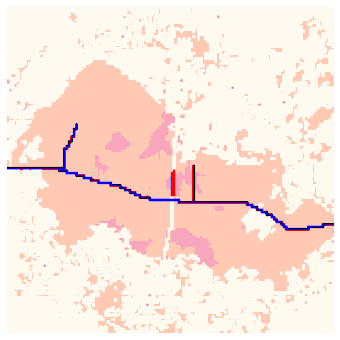

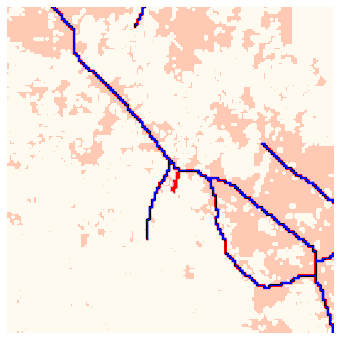

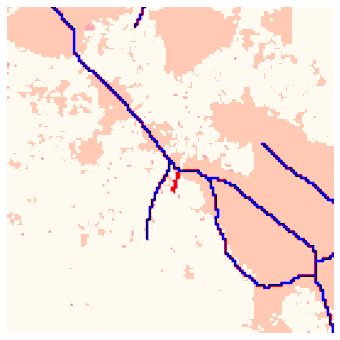

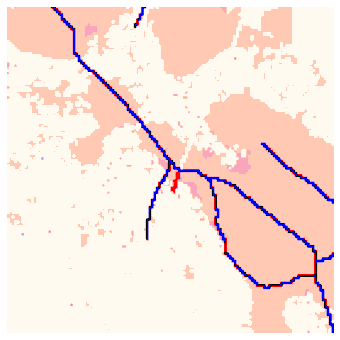

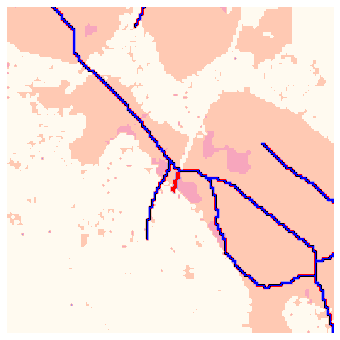

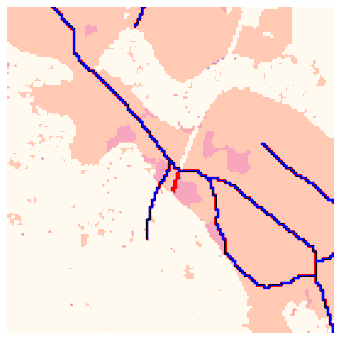

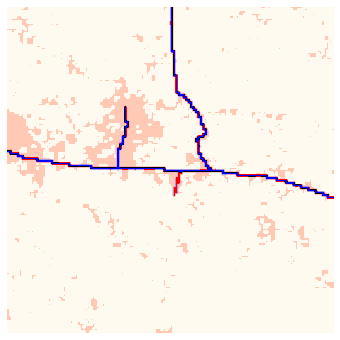

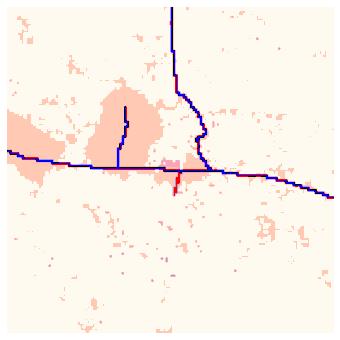

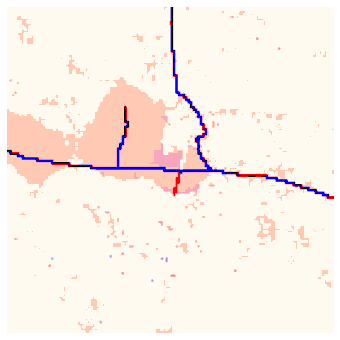

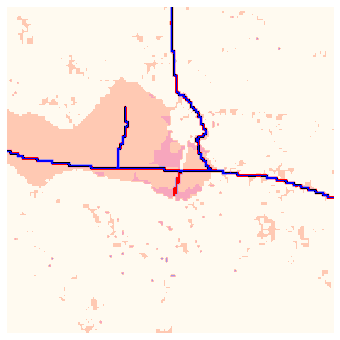

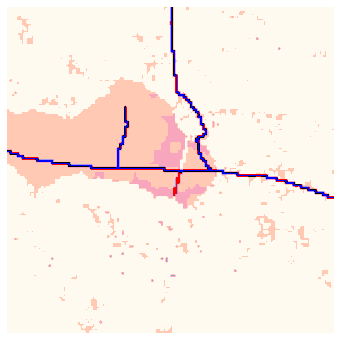

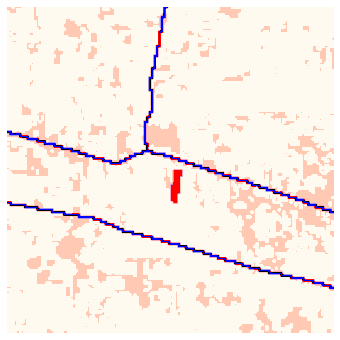

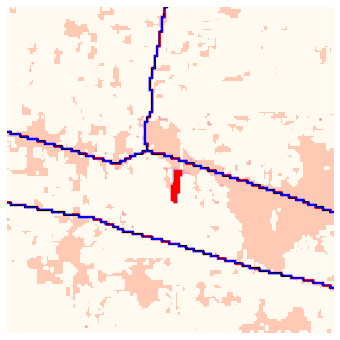

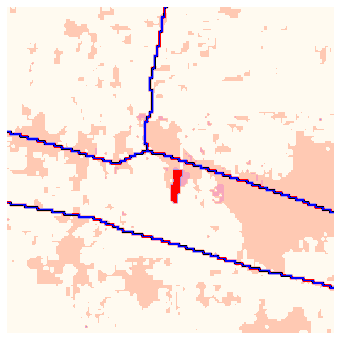

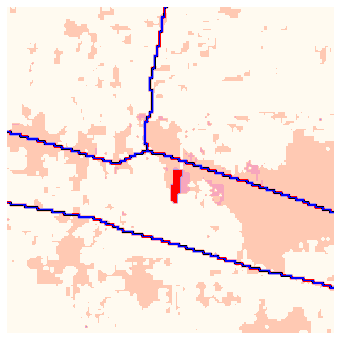

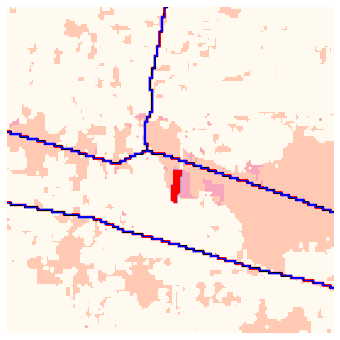

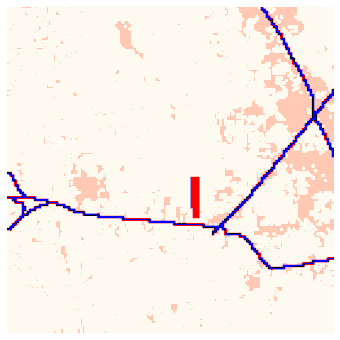

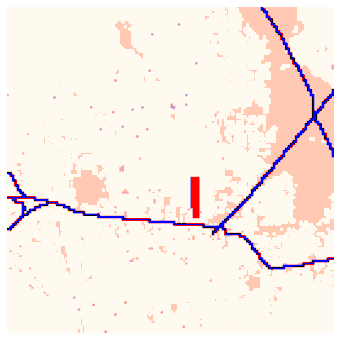

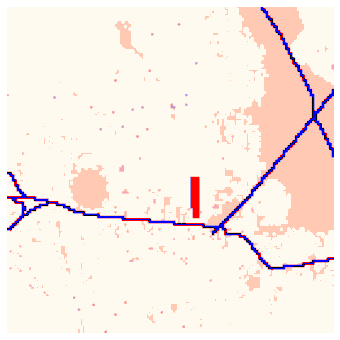

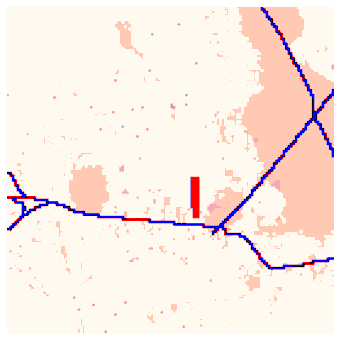

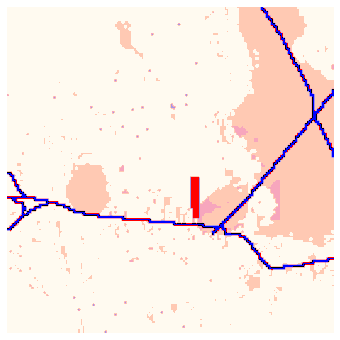

In [90]:
%%time
start_year = 2022
years = [2022, 2027, 2032, 2037, 2042]
stations = ['Virar', 'Boisar', 'Vapi', 'Billimora', 'Surat', 'Bharuch']

ymin = 100
ymax = 234
xmin = 100
xmax = 234
plt.rcParams['figure.max_open_warning'] = 0

for station_name in stations:
    print(station_name)
    new_maps = All_maps[stations.index(station_name)]
    roads_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_roads.tif'))
    stn_2022 = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_HSR_stn.tif'))

    roads = [roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax]]
    station = [stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax]]

    rails = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_rail.tif'))[ymin:ymax, xmin:xmax]
    DEM = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_DEM.tif'))[1:-1,1:-1]
    slope = np.array(Image.open(r'D:/GIS/Greenfield_HSR_stn/'+station_name+'/'+station_name+'_slope.tif'))[1:-1,1:-1]
    elevations = np.empty(np.shape(new_maps))
    gradient = np.empty(np.shape(new_maps))
    stn_building_height = np.empty(np.shape(new_maps))

    all_roads = np.copy(roads[-1])
    all_stn = np.copy(station[-1])
    for i in range(np.shape(new_maps)[0]):
        new_maps[i][rails==102] = 0
        new_maps[i][all_stn==85] = 0
        new_maps[i][station[i]==85] = 85
        new_maps[i][all_roads==119] = 0
        new_maps[i][roads[i]==119] = 119
        elevations[i] = DEM[ymin:ymax, xmin:xmax]
        gradient[i] = slope[ymin:ymax, xmin:xmax]
        stn_building_height[i] = np.multiply(np.ones(np.shape(new_maps[i])), new_maps[i]==68)

    building_height_proportion = np.zeros([5, 4])
    for p in range(4):
        building_height_proportion[0][p] = (np.sum(stn_building_height[0]==p)/(np.shape(stn_building_height)[1]*np.shape(stn_building_height)[2]))*100
    
    for i in range(1,5):
        neighbourhood_size = 15
        id_all = np.array([[1],[2],[3],[4]])
        d_max = 16
        stn_dist = np.ones(np.shape(station))*d_max
        stn_dist = distance_calculator(station, 85, 30, stn_dist)
        road_dist = np.ones(np.shape(roads))*d_max
        road_dist = distance_calculator(roads, 119, 30, road_dist)

        [self_water, self_green, self_barren, self_builtup, self_road] = intrinsic_values(new_maps, [17,34,51,68,119])
        [neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_road], neighbourhood_size)
        
        [self_low, self_mid, self_high] = intrinsic_values(stn_building_height, [1,2,3])
        [neighbour_low, neighbour_mid, neighbour_high] = Cellular_Automata([self_low, self_mid, self_high], neighbourhood_size//3)

        X1 = prepare_data(self_builtup[i:i+1])
        X_main = prepare_data(neighbour_builtup[0:1])
        
        X6 = prepare_data(neighbour_low[0:1])
        X7 = prepare_data(neighbour_mid[0:1])
        X8 = prepare_data(neighbour_high[0:1])
        X9 = prepare_data(neighbour_road[0:1])
        
        X_stn = prepare_data(stn_dist[0:1])
        X10 = np.zeros(np.shape(X_stn))
        X10[X_stn<=0.25] = 1
        X_stn[X_stn<=0.25] = d_max
        X11 = np.zeros(np.shape(X_stn))
        X11[X_stn<=0.5] = 1
        X_stn[X_stn<=0.5] = d_max
        X12 = np.zeros(np.shape(X_stn))
        X12[X_stn<=1] = 1
        X_stn[X_stn<=1] = d_max
        X13 = np.zeros(np.shape(X_stn))
        X13[X_stn<=2] = 1
        X_stn[X_stn<=2] = d_max

        X_road = prepare_data(road_dist[0:1])
        X14 = np.zeros(np.shape(X_road))
        X14[X_road<=0.125] = 1
        X_road[X_road<=0.125] = d_max
        X15 = np.zeros(np.shape(X_road))
        X15[X_road<=0.25] = 1
        X_road[X_road<=0.25] = d_max
        X16 = np.zeros(np.shape(X_road))
        X16[X_road<=0.5] = 1
        X_road[X_road<=0.5] = d_max
        X17 = np.zeros(np.shape(X_road))
        X17[X_road<=1] = 1
        X_road[X_road<=1] = d_max

        X18 = prepare_data(gradient[0:1])
        X18[X18<=5] = 1
        X18[X18>5] = 0
        X19 = prepare_data(elevations[0:1])
        X19 = X19/100
        X0 = np.ones(np.shape(X1))
        xcheck_height = np.transpose([X1,X0,X_main,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17])
        index2 = xcheck_height[:,0]
        print(np.shape(xcheck_height))
        xcheck_height[index2!=1,:] = 0
        print(np.shape(xcheck_height))
        
        y_pred_h = classifier_height.predict(xcheck_height[:,1:])
        
        map_new = np.reshape(y_pred_h,[(ymax-ymin),(xmax-xmin)])
        map_new[new_maps[i]==85] = 4
        map_new[new_maps[i]==102] = 5
        map_new[new_maps[i]==119] = 6
        map_new[new_maps[i]==0] = 0
        
        stn_building_height[i] = map_new
        
        for p in range(4):
            building_height_proportion[i][p] = (np.sum(stn_building_height[i]==p)/(np.shape(stn_building_height)[1]*np.shape(stn_building_height)[2]))*100

    print('changes for '+station_name +':', building_height_proportion)
    
    stn_building_height[0][new_maps[i]==85] = 4
    stn_building_height[0][new_maps[i]==102] = 5
    stn_building_height[0][new_maps[i]==119] = 6
    stn_building_height[0][new_maps[i]==0] = 0

    for i in range(5):
        fig = plt.figure(figsize=(6,6))
        plt.axis('off')
        plt.imshow(stn_building_height[i], cmap_height)